run script color_gi_run22i.py in desc-stack-weekly kernel first

In [1]:
# This script is compatible with desc-stack-weekly kernel.
%matplotlib inline
import sqlite3
import os
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
import data_process_utils as dpu
import matplotlib.pyplot as plt
import seaborn as sns
import lsst.afw.image as afwImage
from lsst.geom import Point2D, Point2I
import lsst.geom as geom

def get_skycoords_from_src(src):
    ra = src.coord_ra.map(np.rad2deg)
    dec = src.coord_dec.map(np.rad2deg)
    coord = SkyCoord(ra, dec, frame="icrs", unit="deg")
    return coord

def remove_src_with_flags(src_df, flag_list=None):
    flags = src_df.loc[:, flag_list]
    keep_id = (flags.sum(axis=1) == 0).to_numpy()
    return src_df[keep_id].copy().reset_index(drop=True)

def keep_src_with_flags(src_df, flag_list=None):
    flags = src_df.loc[:, flag_list]
    keep_id = (flags.sum(axis=1) > 0).to_numpy()
    return src_df[keep_id].copy().reset_index(drop=True)

SAT_FLAGS = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
              'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_bad']
DIPOLE_FLAGS = ['ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']

def get_truth_type(val):
    # truth_type: 1 for galaxies, 2 for stars, and 3 for SNe
    if int(val) == 1:
        return 'galaxy'
    elif int(val) == 2:
        return 'star'
    elif int(val) == 3:
        return SN
    else:
        return 'uknown'
    


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.7.0/lib/python3.8/site-packages/GCRCatalogs/register.py:159: UserWarning: Site determined from env variable DESC_GCR_SITE = nersc, which differs from node name login34.chn
  warnings.warn("Site determined from env variable {} = {}, which differs from node name {}".format(


In [2]:
# read image files
data_dir = '/pscratch/sd/s/shl159/Cori/projects/fake_injection_v23/dia_improvement/devel/data'
image_table = pd.read_csv(os.path.join(data_dir, 'table/gal_4639/image_info_20_21_m20.csv'))
# get artifact
db = f'/pscratch/sd/s/shl159/Cori/projects/fake_injection_v23/dia_improvement/devel/data/patch_0to6/diff/al_default_v23/detection/detection.sqlite'
conn = sqlite3.connect(db)
mag = 20
artifacts = pd.read_sql_query(f"SELECT * FROM artifact WHERE host_mag = '20_21' and fake_mag = {mag}", conn)
# backgropund sources
bk_src_dir = './background_sources_run22i/'

In [3]:
color_df = pd.DataFrame()
for idx, row in image_table.iterrows():
    # get exp
    diff_path = row['diffexp_path'].replace('./data', data_dir)
    diffexp =  afwImage.ExposureF(diff_path)
    bbox = diffexp.getBBox()
    wcs = diffexp.getWcs()
    # get visit and detector
    visit = int(row['visit'])
    det = int(row['detector'])
    # get coords of artifacts
    selected_art = artifacts[np.logical_and(artifacts.visit == visit, artifacts.detector == det)]
    art_coord = get_skycoords_from_src(selected_art)
    # get saturation artifacts
    sat = keep_src_with_flags(selected_art, flag_list=['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter'])
    sat_coord = get_skycoords_from_src(sat)
    # get dipole artifacts
    nonsat = remove_src_with_flags(selected_art, flag_list=['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter'])
    dipole = keep_src_with_flags(nonsat, flag_list=DIPOLE_FLAGS)
    dipole_coord = get_skycoords_from_src(dipole)
    # get coords of background sources
    # remove source outside of the image
    bk_src =pd.read_csv(os.path.join(bk_src_dir, f'{visit}_{det}_run22i.csv'))
    in_image = bk_src.apply(lambda row: radec_in_image(row['ra'], row['dec'], bbox, wcs), axis=1)
    bk_src = bk_src[in_image].copy().reset_index()
    bk_coord = SkyCoord(bk_src.ra, bk_src.dec, frame="icrs", unit="deg")
    bk_src['matched_status_full'] = np.repeat(False, len(bk_src))
    bk_src['matched_status_dipole'] = np.repeat(False, len(bk_src))
    bk_src['matched_status_saturation'] = np.repeat(False, len(bk_src))
    # coords matching
    if len(art_coord) > 0 and len(bk_coord) > 0:
        matched_status_full, matched_id_full = dpu.two_direction_skymatch(bk_coord, art_coord, radius=2 * u.arcsec)
        bk_src['matched_status_full'] = matched_status_full
    if len(dipole_coord) > 0 and len(bk_coord) > 0:
        matched_status_dipole, matched_id_dipole = dpu.two_direction_skymatch(bk_coord, dipole_coord, radius=2 * u.arcsec)
        bk_src['matched_status_dipole'] = matched_status_dipole
    if len(sat_coord) > 0 and len(bk_coord) > 0:
        matched_status_sat, matched_id_sat = dpu.two_direction_skymatch(bk_coord, sat_coord, radius=2 * u.arcsec)
        bk_src['matched_status_sat'] = matched_status_sat        
    color_df = pd.concat([color_df, bk_src], ignore_index=True)

15.302256


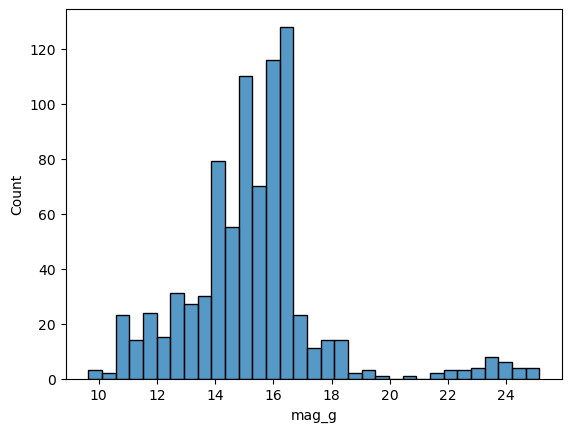

In [4]:
# saturation level
saturation = color_df[color_df.matched_status_sat == True].copy().reset_index()
sns.histplot(saturation, x='mag_g')
print(saturation.mag_g.median())

In [17]:
sat.filter(like='Dipole').columns

Index(['ip_diffim_NaiveDipoleCentroid_flag',
       'ip_diffim_NaiveDipoleCentroid_pos_flag',
       'ip_diffim_NaiveDipoleCentroid_neg_flag',
       'ip_diffim_NaiveDipoleCentroid_x', 'ip_diffim_NaiveDipoleCentroid_y',
       'ip_diffim_NaiveDipoleCentroid_xErr',
       'ip_diffim_NaiveDipoleCentroid_yErr',
       'ip_diffim_NaiveDipoleCentroid_pos_x',
       'ip_diffim_NaiveDipoleCentroid_pos_y',
       'ip_diffim_NaiveDipoleCentroid_pos_xErr',
       'ip_diffim_NaiveDipoleCentroid_pos_yErr',
       'ip_diffim_NaiveDipoleCentroid_neg_x',
       'ip_diffim_NaiveDipoleCentroid_neg_y',
       'ip_diffim_NaiveDipoleCentroid_neg_xErr',
       'ip_diffim_NaiveDipoleCentroid_neg_yErr',
       'ip_diffim_NaiveDipoleFlux_flag', 'ip_diffim_NaiveDipoleFlux_pos_flag',
       'ip_diffim_NaiveDipoleFlux_neg_flag',
       'ip_diffim_NaiveDipoleFlux_pos_instFlux',
       'ip_diffim_NaiveDipoleFlux_pos_instFluxErr',
       'ip_diffim_NaiveDipoleFlux_neg_instFlux',
       'ip_diffim_NaiveDipoleFlux_ne

In [5]:
# truth_type: 1 for galaxies, 2 for stars, and 3 for SNe
color_gi = color_df[['mag_g', 'mag_i', 'matched_status_full', 'matched_status_dipole', 'truth_type']].copy()
color_gi = color_gi[color_gi.mag_g > 14].copy().reset_index()
# calculate color gi
mag_gi = color_gi.mag_g - color_gi.mag_i
color_gi.insert(3, 'mag_gi', mag_gi)

# get truth name
truth_name = color_gi.truth_type.map(get_truth_type).copy()
color_gi.insert(6, 'truth_name', truth_name)
# get star and galaxy dataframes
star = color_gi[color_gi.truth_name == 'star'].copy()
galaxy = color_gi[color_gi.truth_name == 'galaxy'].copy()
print(len(star) + len(galaxy), len(color_gi))
print(color_gi.truth_name.unique())
# (star.mag_g > 14).sum(), len(star), (galaxy.mag_g > 14).sum(), len(galaxy)

129012 129012
['star' 'galaxy']


In [6]:
def cal_fraction(arr):
    return arr.astype(int).sum() / len(arr)

def cal_count(arr):
    return len(arr)

def get_heatmap(df, x_nbins, y_nbins):
    df_copy = df.copy()
    mag_g_bin = pd.cut(df_copy['mag_g'], bins=x_nbins, labels=False, include_lowest=True)
    df_copy['mag_g_bin'] = mag_g_bin
    mag_gi_bin = pd.cut(df_copy['mag_gi'], bins=y_nbins, labels=False, include_lowest=True)
    df_copy['mag_gi_bin'] = mag_gi_bin
    # df_copy['mag_g_mean'] = df_copy.groupby('mag_g_bin')['mag_g'].transform('mean').copy()
    # df_copy['mag_gi_mean'] = df_copy.groupby('mag_gi_bin')['mag_gi'].transform('mean').copy()
    # heatmap = df_copy.groupby(['mag_g_mean', 'mag_gi_mean']).agg({'matched_status_full': cal_fraction, 'matched_status_dipole': cal_fraction}).reset_index()
    df_copy['n_sources'] = np.repeat(0, len(df_copy))
    heatmap = df_copy.groupby(['mag_g_bin', 'mag_gi_bin']).agg({'matched_status_full': cal_fraction,
                                                                'matched_status_dipole': cal_fraction,
                                                                'n_sources': cal_count}).reset_index()
    heatmap = heatmap.rename(columns={"matched_status_full": "artifact_fraction", "matched_status_dipole": "dipole_fraction"})
    return heatmap

def plot_heatmap(heatmap, xticklabels, yticklabels, index='mag_gi_bin', column='mag_g_bin', value='artifact_fraction', title='Heatmap for Artifact Fraction'):
    heatmap_data = heatmap.pivot(index=index, columns=column, values=value)
    heatmap_annot = heatmap.pivot(index=index, columns=column, values='n_sources')
    plt.figure(figsize=(12, 12))
    sns.heatmap(heatmap_data, annot=heatmap_annot.to_numpy().astype(int), cmap='coolwarm', fmt='d', linewidths=.5)
    print(plt.xticks()[0], plt.yticks()[0])
    plt.xticks(ticks=np.arange(len(xticklabels)), labels=np.round(xticklabels, 2))
    plt.yticks(ticks=np.arange(len(yticklabels)), labels=np.round(yticklabels, 2))
    
    plt.gca().invert_yaxis()
    plt.xticks(rotation=0)
    plt.title(title)
    plt.xlabel('mag g')
    plt.ylabel('mag g - mag i')
    
xbins = list(range(14, 28, 1))
ybins = list(np.arange(-0.8, 4.7, 0.5))

In [7]:
# choose bin range, star and galaxy have different bin range
star.mag_gi.max(), star.mag_gi.min(), star.mag_g.max(), star.mag_g.min()

(4.188818000000001, -0.5792649999999995, 26.999084, 14.00667)

[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5] [0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]


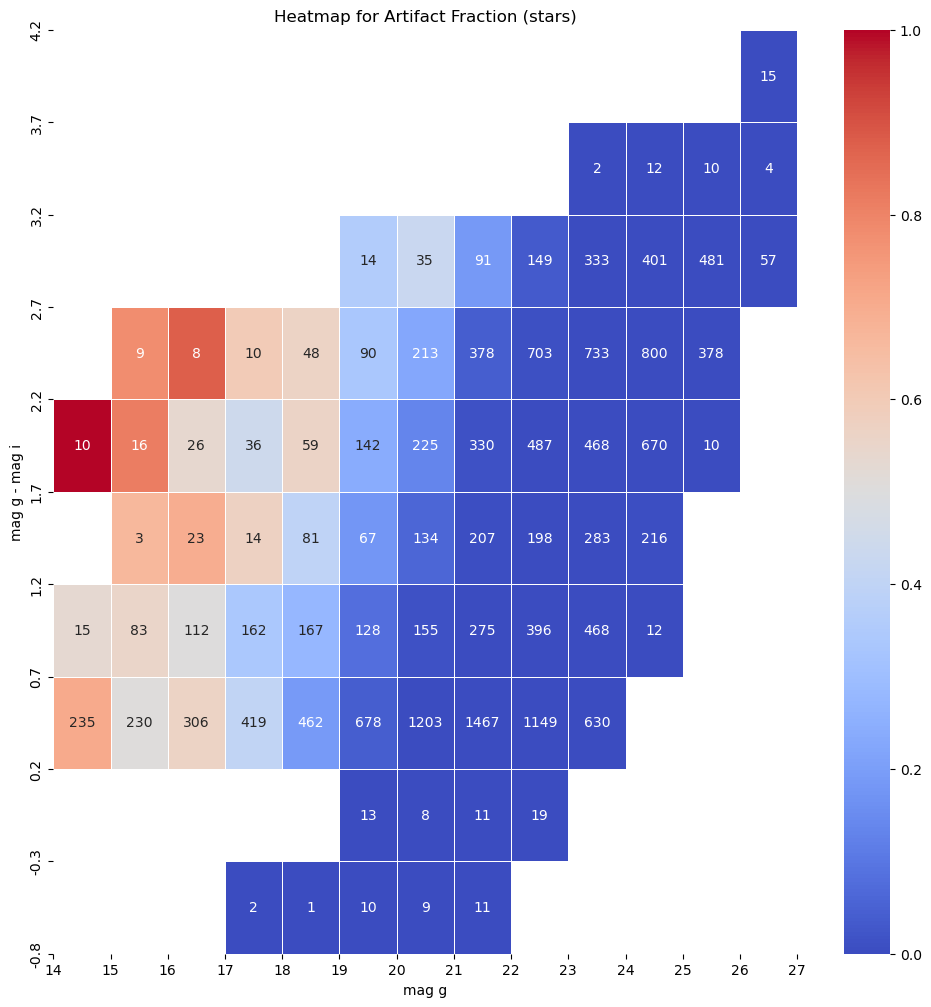

In [8]:
xbins = list(range(14, 28, 1))
ybins = list(np.arange(-0.8, 4.7, 0.5))
value = 'artifact_fraction'
title = 'Heatmap for Artifact Fraction (stars)'
heatmap = get_heatmap(star, xbins, ybins)
plot_heatmap(heatmap, xbins, ybins, value=value, title=title)
plt.savefig('heatmap_star.png', dpi=100)

In [9]:
len(star[
    np.logical_and(
        np.logical_and(star.mag_g > 21, star.mag_g<22),
        np.logical_and(star.mag_gi>0.2, star.mag_gi<0.7))])

1467

[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5] [0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]


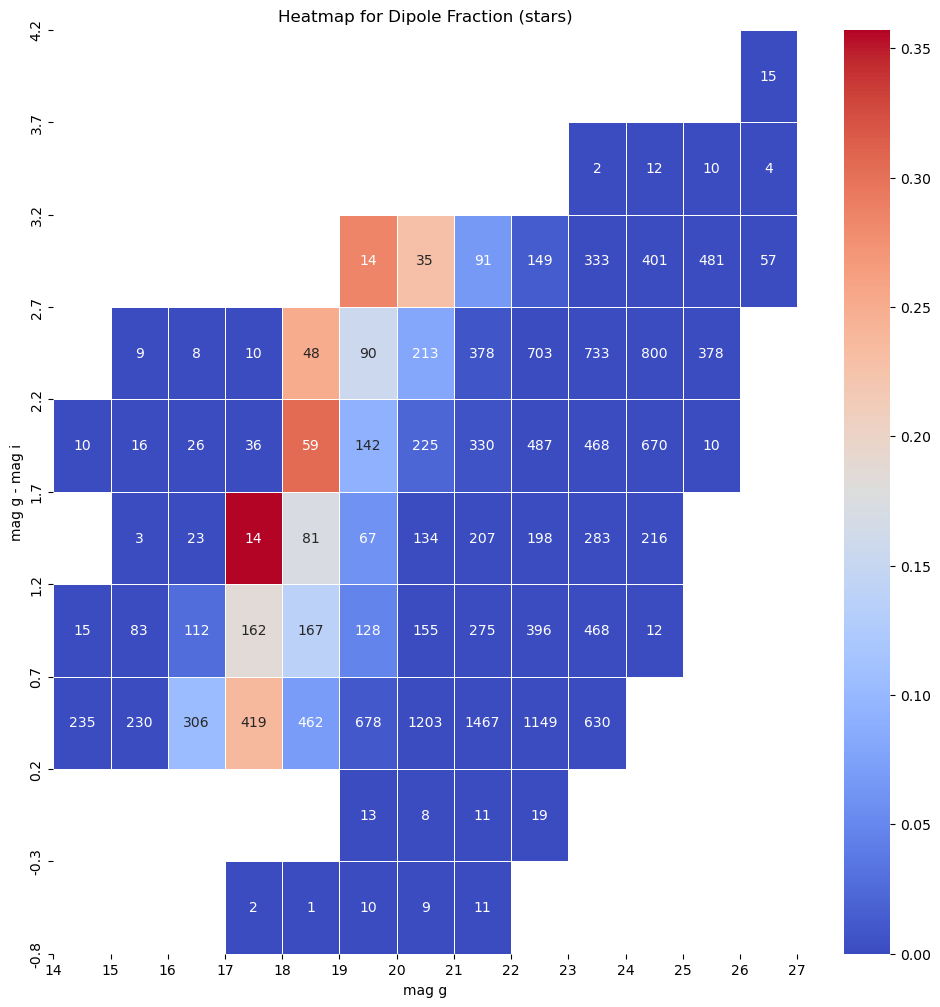

In [10]:
xbins = list(range(14, 28, 1))
ybins = list(np.arange(-0.8, 4.7, 0.5))
value = 'dipole_fraction'
title = 'Heatmap for Dipole Fraction (stars)'
heatmap = get_heatmap(star, xbins, ybins)
plot_heatmap(heatmap, xbins, ybins, value=value, title=title)
plt.savefig('heatmap_star_dipole.png', dpi=100)

#### galaxy

In [11]:
# we need to adjust the bins
galaxy.mag_gi.min(), galaxy.mag_gi.max(), galaxy.mag_g.min(), galaxy.mag_g.max()

(-0.43664900000000273, 3.2651310000000002, 15.208777, 26.026533)

[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5] [0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5]


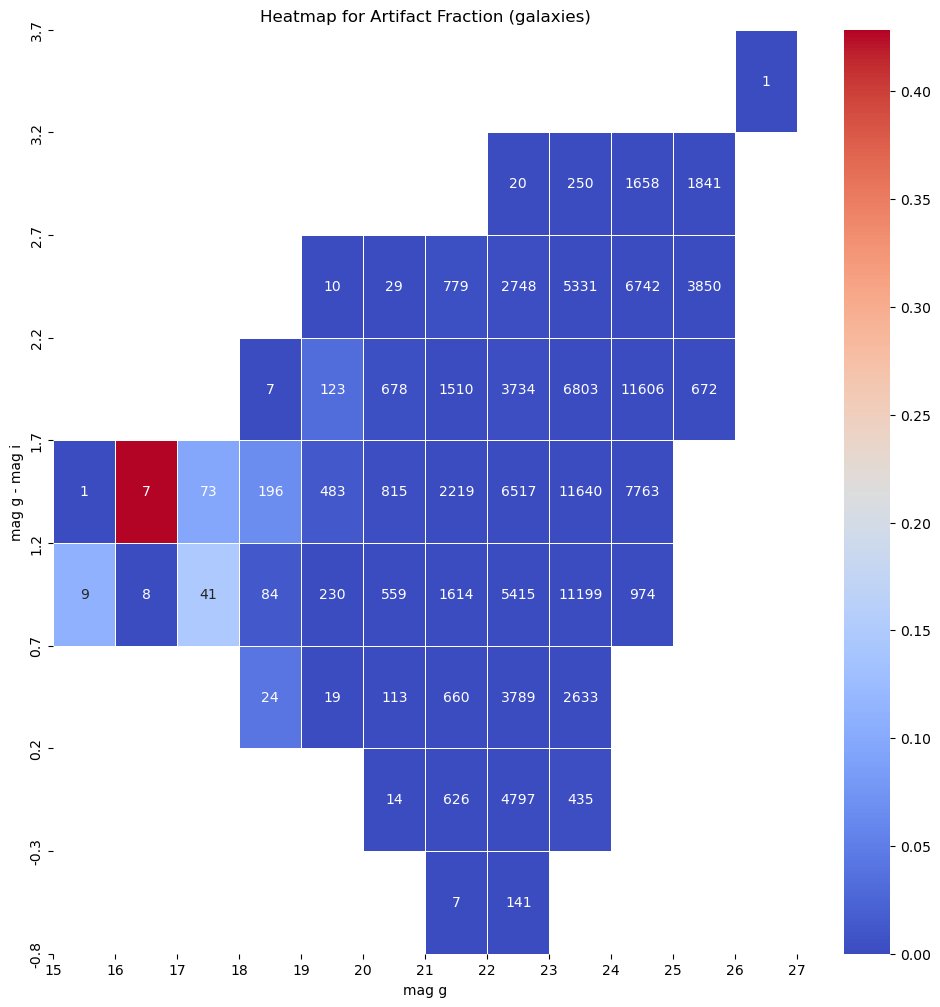

In [12]:
xbins = list(range(15, 28, 1))
ybins = list(np.arange(-0.8, 4.2, 0.5))
value = 'artifact_fraction'
title = 'Heatmap for Artifact Fraction (galaxies)'
heatmap = get_heatmap(galaxy, xbins, ybins)
plot_heatmap(heatmap, xbins, ybins, value=value, title=title)
plt.savefig('heatmap_galaxy.png', dpi=100)

In [13]:
len(galaxy[
    np.logical_and(
        np.logical_and(galaxy.mag_g > 18, galaxy.mag_g<19),
        np.logical_and(galaxy.mag_gi>1.2, galaxy.mag_gi<1.7))])

196

[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5] [0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5]


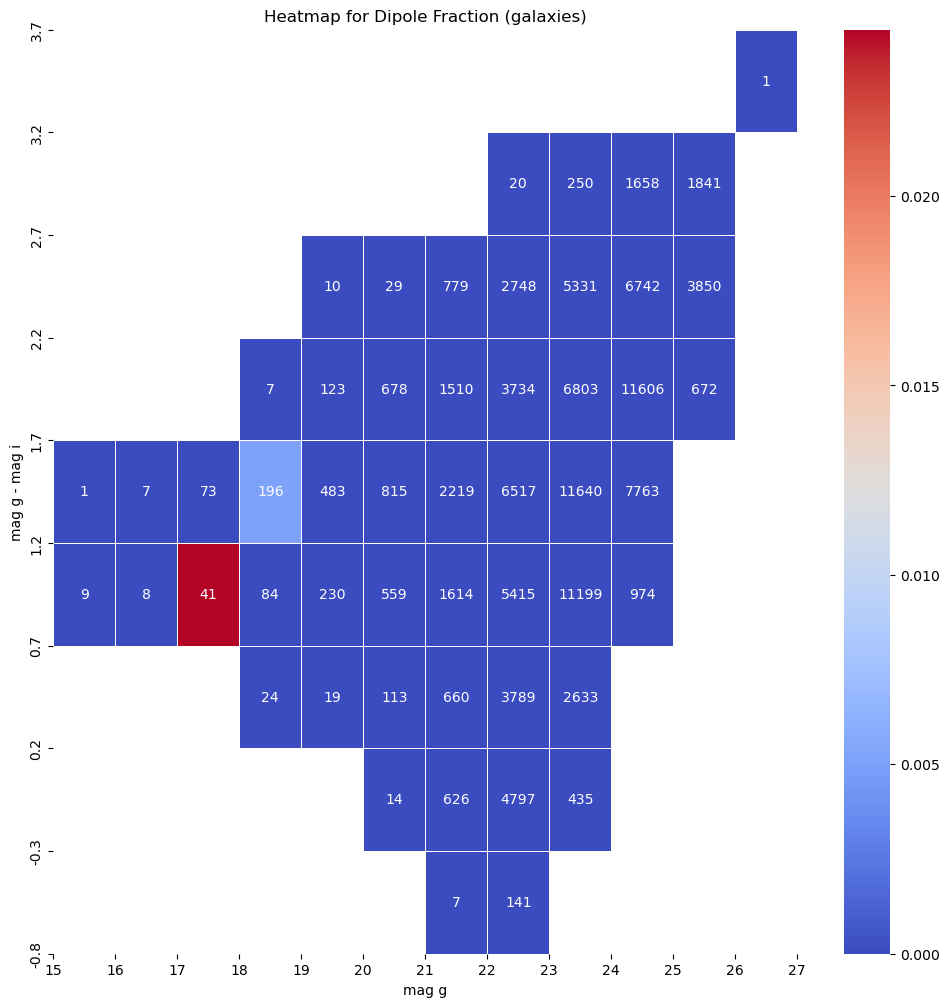

In [14]:
xbins = list(range(15, 28, 1))
ybins = list(np.arange(-0.8, 4.2, 0.5))
value = 'dipole_fraction'
title = 'Heatmap for Dipole Fraction (galaxies)'
heatmap = get_heatmap(galaxy, xbins, ybins)
plot_heatmap(heatmap, xbins, ybins, value=value, title=title)
plt.savefig('heatmap_galaxy_dipole.png', dpi=100)

In [15]:
len(galaxy[
    np.logical_and(
        np.logical_and(galaxy.mag_g > 19, galaxy.mag_g<20),
        np.logical_and(galaxy.mag_gi>1.2, galaxy.mag_gi<1.7))])

483

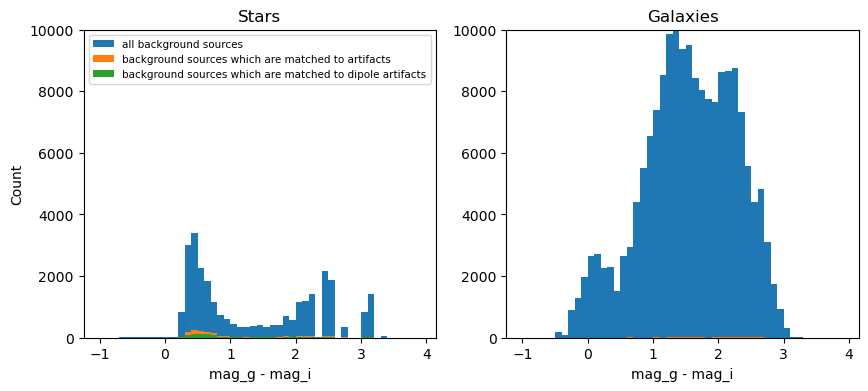

In [46]:
bins=np.arange(-1, 4, 0.1)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
dfs = [star, galaxy]
titles = ['Stars', 'Galaxies']
for i, df in enumerate(dfs):
    ax[i].hist(df.mag_gi, bins=bins, label='all background sources')
    ax[i].hist(df[df.matched_status_full].mag_gi, bins=bins, label='background sources which are matched to artifacts');
    ax[i].hist(df[df.matched_status_dipole].mag_gi, bins=bins, label='background sources which are matched to dipole artifacts');
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('mag_g - mag_i')
    ax[i].set_ylim(0, 10000)
    if i == 0:
        ax[i].set_ylabel('Count')
        ax[i].legend(fontsize=7.5)
plt.savefig('colorgi.png', dpi=100)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.7.0/lib/python3.8/site-packages/seaborn/axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


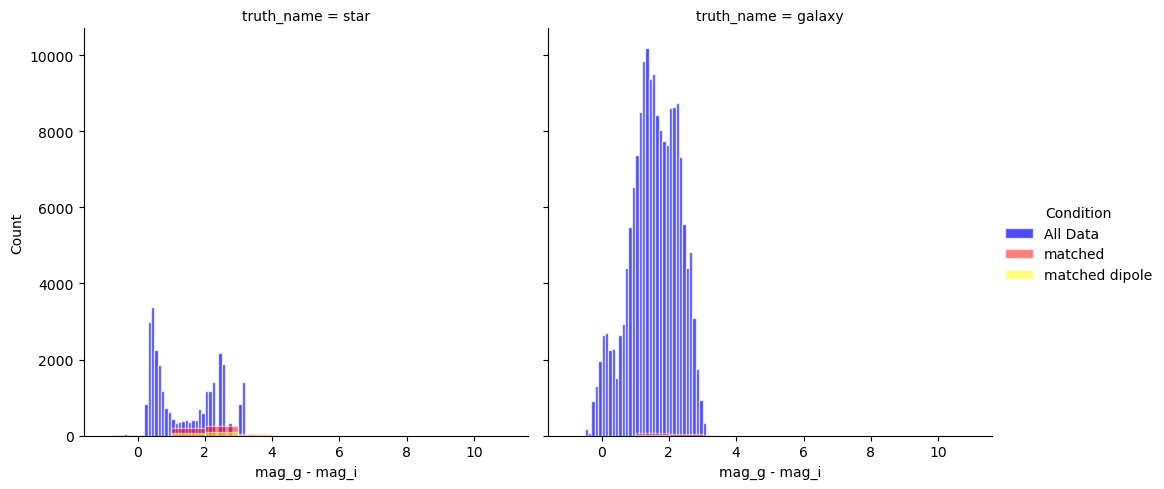

In [38]:
g = sns.FacetGrid(color_gi, col="truth_name", height=5)
g.map(plt.hist, 'mag_gi', bins=np.arange(-1, 4, 0.1), color='blue', alpha=0.7, edgecolor='w')
for ax, category in zip(g.axes.flat, ['star', 'galaxy']):
    data_category = color_gi[(color_gi['truth_name'] == category) & (color_gi['matched_status_full'] == True)]
    ax.hist(data_category['mag_gi'], bins=range(1, 12), color='red', alpha=0.5, edgecolor='w')
for ax, category in zip(g.axes.flat, ['star', 'galaxy']):
    data_category = color_gi[(color_gi['truth_name'] == category) & (color_gi['matched_status_dipole'] == True)]
    ax.hist(data_category['mag_gi'], bins=range(1, 12), color='yellow', alpha=0.5, edgecolor='w')
# Add labels and legend
g.set_axis_labels('mag_g - mag_i', 'Count')
g.add_legend(title='Condition', labels=['All Data', 'matched', 'matched dipole'])
# Show the plot
plt.show()

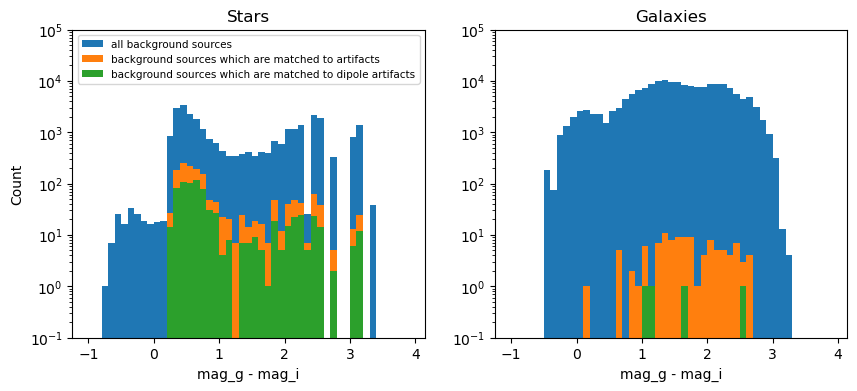

In [32]:
bins=np.arange(-1, 4, 0.1)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
dfs = [star, galaxy]
titles = ['Stars', 'Galaxies']
for i, df in enumerate(dfs):
    ax[i].hist(df.mag_gi, bins=bins, label='all background sources')
    ax[i].hist(df[df.matched_status_full].mag_gi, bins=bins, label='background sources which are matched to artifacts');
    ax[i].hist(df[df.matched_status_dipole].mag_gi, bins=bins, label='background sources which are matched to dipole artifacts');
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('mag_g - mag_i')
    ax[i].set_ylim(0.1, 1e5)
    ax[i].set_yscale('log')
    if i == 0:
        ax[i].set_ylabel('Count')
        ax[i].legend(fontsize=7.5)
plt.savefig('colorgi_log.png', dpi=100)

Text(0.5, 0, 'mag_g - mag_i')

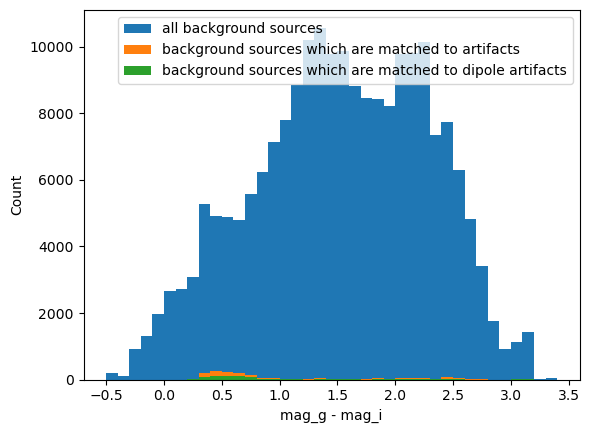

In [10]:
plt.hist(color_gi.mag_gi, bins=np.arange(-0.5, 3.5, 0.1), label='all background sources')
plt.hist(color_gi[color_gi.matched_status_full].mag_gi, bins=np.arange(-0.5, 3.5, 0.1), label='background sources which are matched to artifacts');
plt.hist(color_gi[color_gi.matched_status_dipole].mag_gi, bins=np.arange(-0.5, 3.5, 0.1), label='background sources which are matched to dipole artifacts');
plt.legend()
plt.ylabel('Count')
plt.xlabel('mag_g - mag_i')
# plt.savefig('colorgi.png', dpi=100)

Text(0.5, 0, 'mag_g - mag_i')

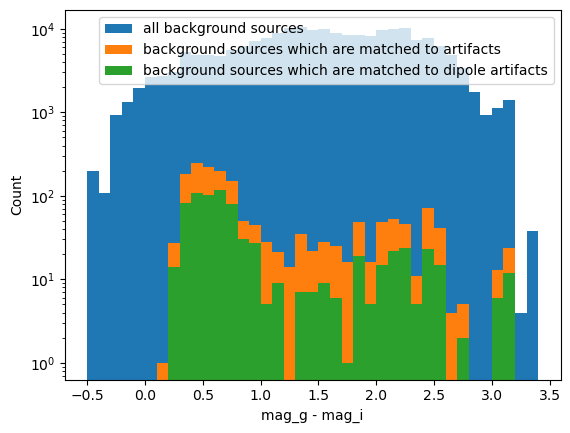

In [11]:
plt.hist(color_gi.mag_gi, bins=np.arange(-0.5, 3.5, 0.1), label='all background sources')
plt.hist(color_gi[color_gi.matched_status_full].mag_gi, bins=np.arange(-0.5, 3.5, 0.1), label='background sources which are matched to artifacts');
plt.hist(color_gi[color_gi.matched_status_dipole].mag_gi, bins=np.arange(-0.5, 3.5, 0.1), label='background sources which are matched to dipole artifacts');
plt.yscale('log')
plt.legend()
plt.ylabel('Count')
plt.xlabel('mag_g - mag_i')
# plt.savefig('colorgi_log.png', dpi=100)

In [94]:
artifacts.filter(like='flag')

,flags_negative,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_PeakCentroid_flag,base_SdssCentroid_flag,base_SdssCentroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,...,ip_diffim_DipoleFit_flag_classification,ip_diffim_DipoleFit_flag_classificationAttempted,ip_diffim_DipoleFit_flag,ip_diffim_DipoleFit_flag_edge,base_GaussianFlux_flag_apCorr,base_PsfFlux_flag_apCorr,slot_PsfFlux_flag_apCorr,ip_diffim_forced_PsfFlux_flag,ip_diffim_forced_PsfFlux_flag_noGoodPixels,ip_diffim_forced_PsfFlux_flag_edge
0,0,1,0,0,1,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2441,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2442,0,0,0,0,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,0
2443,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2444,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# truth type
# truth_type: 1 for galaxies, 2 for stars, and 3 for SNe
# https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md